In [ ]:
# Exact same code; just running it again with more test data to ensure more values in the 'hispanic' group
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations, chain
from sklearn.linear_model import LogisticRegression

In [ ]:
# Cleaned following https://github.com/amazon-science/minimax-fair/blob/main/src/clean_communities_data.py
df = pd.read_csv('communities_cleaned.csv')

print(df.shape)
display(df.columns)
df.head()

(1994, 102)


Index(['0', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       ...
       '96', '97', '98', '99', '100', '118', '119', '120', '125', '127'],
      dtype='object', length=102)

,0,4,5,6,7,8,9,10,11,12,...,96,97,98,99,100,118,119,120,125,127
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [ ]:
# To see what each column means (i.e., the feature name), see: https://github.com/algowatchpenn/GerryFair/blob/master/dataset/communities.csv

In [ ]:
original_data = pd.read_csv('communities_cleaned.csv')
target_col_name = '127' # this is what we are trying to predict (i..e, y)
data = original_data.drop(columns=[target_col_name], axis = 1), original_data[target_col_name] # Can delete this; I'm defining the right data below

In [ ]:
data = df.iloc[:, 0:101].values
y = df['127'].values

In [ ]:
def GFG(arr,prec): # Print without scientific notation
    np.set_printoptions(suppress=True,precision=prec)
    print(arr)

print(GFG(data, 3))

[[ 8.    1.    0.19 ...  0.26  0.2   0.32]
 [53.    1.    0.   ...  0.12  0.45  0.  ]
 [24.    1.    0.   ...  0.21  0.02  0.  ]
 ...
 [ 9.   10.    0.16 ...  0.32  0.18  0.91]
 [25.   10.    0.08 ...  0.38  0.33  0.22]
 [ 6.   10.    0.2  ...  0.3   0.05  1.  ]]
None


In [ ]:
print(y)

[0.2  0.67 0.43 ... 0.23 0.19 0.48]


In [ ]:
# For everything conformal prediction related, we will be using the MAPIE library
%pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])

# Split data into training and test sets along with their indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    data, y, indices, test_size=0.3, shuffle=True, random_state=42
)

#X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, shuffle=True, random_state=42)

In [ ]:
print(idx_test)

In [ ]:
print("Shape of training input : ", X_train.shape)
print("Shape of training output : ",y_train.shape)
print("Shape of testing input : ", X_test.shape)
print("Shape of testing output : ",y_test.shape)

Shape of training input :  (1395, 101)
Shape of training output :  (1395,)
Shape of testing input :  (599, 101)
Shape of testing output :  (599,)


[0.932]


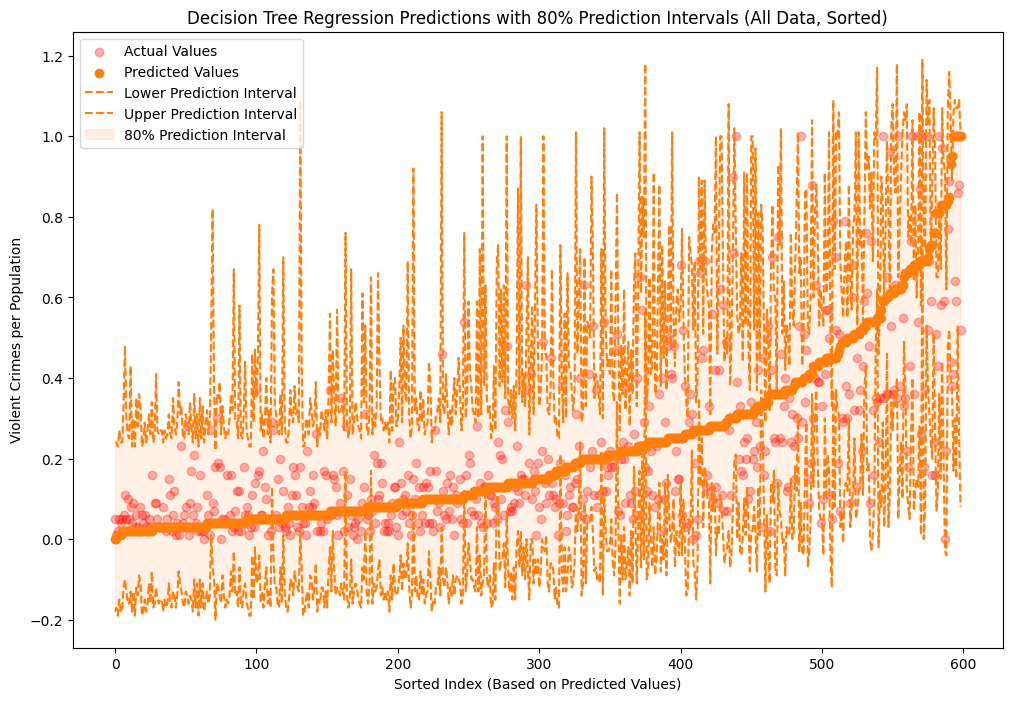

In [ ]:
# Using Decision Trees (more refined confidence intervals)
from typing import Union, Optional
from typing_extensions import TypedDict
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.subsample import Subsample
from mapie.metrics import regression_coverage_score_v2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

#regressor = LinearRegression() # For real valued
#regressor = RandomForestRegressor(random_state=42) # For real valued
regressor = DecisionTreeRegressor(random_state=42)
mapie_regressor = MapieRegressor(estimator=regressor, method='plus', cv=5)
mapie_regressor.fit(X_train, y_train)
alpha = 0.2
y_pred, y_pis = mapie_regressor.predict(X_test, alpha=alpha)
coverage_scores = regression_coverage_score_v2(y_test, y_pis)
print(coverage_scores)

y_pred = y_pred.flatten()
y_test = y_test.flatten()
y_pis = y_pis.reshape(-1, 2)  # Make sure y_pis is a Nx2 array

# Sorting all data points by the predicted values in increasing order
sort_indices = np.argsort(y_pred)
sorted_y_test = y_test[sort_indices]
sorted_y_pred = y_pred[sort_indices]
sorted_lower_bounds = y_pis[sort_indices, 0]
sorted_upper_bounds = y_pis[sort_indices, 1]

# Use sequential indices corresponding to the sorted predicted values for the X-axis
sequential_indices = np.arange(len(sorted_y_pred))  # Create an array of indices from 0 to len(sorted_y_pred)-1

# Plotting
plt.figure(figsize=(12, 8))
plt.xlabel("Sorted Index (Based on Predicted Values)")
plt.ylabel("Violent Crimes per Population")
plt.scatter(sequential_indices, sorted_y_test, alpha=0.3, color='red', label='Actual Values')
plt.scatter(sequential_indices, sorted_y_pred, color="C1", label='Predicted Values')
plt.plot(sequential_indices, sorted_lower_bounds, "C1", ls="--", label='Lower Prediction Interval')
plt.plot(sequential_indices, sorted_upper_bounds, "C1", ls="--", label='Upper Prediction Interval')
plt.fill_between(sequential_indices, sorted_lower_bounds, sorted_upper_bounds, color="C1", alpha=0.1, label='80% Prediction Interval')
plt.title("Decision Tree Regression Predictions with 80% Prediction Intervals (All Data, Sorted)")
plt.legend()
plt.show()

In [ ]:
y_pis_width = []
y_pis_width_sorted = []

for i in sort_indices:
  y_pis_width.append(abs(y_pis[i, 1] - y_pis[i, 0]))
  y_pis_width_sorted.append(abs(y_pis[i, 1] - y_pis[i, 0]))

y_pis_width_sorted.sort() # y_pis_width keeps them in order coherent with y_pred; and y_pis_width_sorted is in order of magnitude

print(y_pis_width_sorted[0])
print(y_pis_width_sorted[498]) # max value

0.41000000000000003
0.6600000000000001


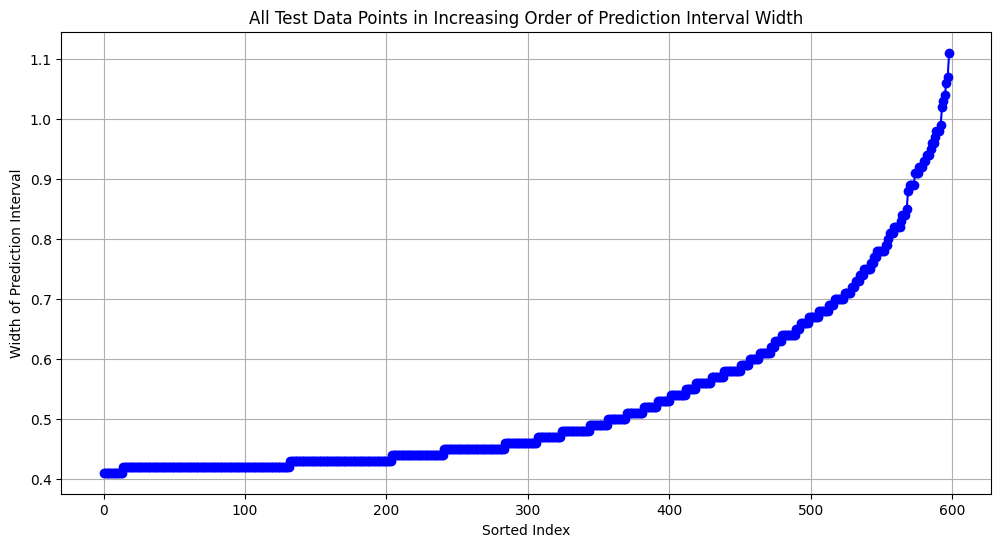

In [ ]:
# Get the indices that would sort the array
sorted_indices = np.argsort(y_pis_width)

# Apply these indices to y_pis_width to sort it
y_pis_width = np.array(y_pis_width).flatten()
sorted_y_pis_width = y_pis_width[sorted_indices]

# Generating indices for the X-axis of the sorted array
x_indices_sorted = np.arange(len(sorted_y_pis_width))

# Plotting
plt.figure(figsize=(12, 6))  # Set the figure size for better visibility
plt.plot(x_indices_sorted, sorted_y_pis_width, marker='o', linestyle='-', color='b')  # Line plot with points
plt.title('All Test Data Points in Increasing Order of Prediction Interval Width') # The wider, the more uncertain we are on that p[oint]
plt.xlabel('Sorted Index')
plt.ylabel('Width of Prediction Interval')
plt.grid(True)  # Turn on grid for easier readability
plt.show()

#print("Sorted indices:", sorted_indices)

In [ ]:
# We will abstain on the 30% of the points with highest width (so the last 30% in the graph)
# This corresponds to 350, which we see above is when the graph picks up
# Try other abstention values, or set the fraction using the standard deviation of the widths

# Get the indices that would sort the array
sorted_indices = np.argsort(y_pis_width)

# Calculate the cutoff for the first 70%
cutoff_index = int(len(sorted_indices) * 0.7)

# Extract the first 70% of the sorted indices
first_70_percent_indices = sorted_indices[:cutoff_index]

print("First 70% indices:", first_70_percent_indices)

First 70% indices: [293 241 184  27 143 134  12  48   1 110 106  10 121 125 441 238 209  36
  34  63  66   2 128  26   0  16 179  78 133 122  89 224  49  95 215  55
  57  59 182 194  87  86 193 156 190 165  76  61  71 219 105 313  22  28
  14 331 343  31  19 364  33  35  20  38 391  40   4 265 379 150 108 147
 403 314 460 145 118 120 136 421 317 130 221 168 220 229 236 210 253 255
 199 196 266 162 192 269 189 283 183 477 296 178 225 169 191 174 203  96
  32  37  90  25  24  80  79  77  94  39  75   5   9  30  58  46  42  52
   3 153 141 312 139 361  67 426 230 226 264 383 257 353 173 208 456 267
 200 294 188 245 160 286 233 288 325 115 232 126 308 324 319 289 357 172
 171 116  54 248  85  13 137 103 144 290  43 114 227  44  64 217 278 117
 529 405  23 352 123 206 214 463 400 151  51 166 254  93 140 518 444 180
   8 306 330 350  91 339 307 239 146  81 164 138 228 327 376 176 129 571
 369 279 448  21 274 504 452 213  62 148  98 345  82 333 158 235 237 104
 311  50 155  18 466 530 459 305

In [ ]:
# Get the indices that would sort the array
sorted_indices = np.argsort(y_pis_width)

# Calculate the starting index for the last 30%
start_index = int(len(sorted_indices) * 0.7)

# Extract the last 30% of the sorted indices
last_30_percent_indices = sorted_indices[start_index:]

# Print the last 30% indices
print("Last 30% indices:", last_30_percent_indices)

Last 30% indices: [440 492  11 442 256 515 462 397 506 579 378 439 422 499 501 479 570 384
 558 565 544   7 152 295 318 270 489 497 581 519 399 409 589 509 568 163
 360 204 554 490 527 250 370 517 354 520 502 375 485 478 332 373 574 555
 297 351 437 531 424 585 271 590 573 564 247 473 398 545 510 415 275 591
 368  88 470 522 513 588 559 575 427 467 536 578 561 556 273 407 511 455
 372 175 549 493 484 119 157 430 580 406 482 483 488 207  84 423 112 566
 338 417 508 392 167 586 309 387 385 186 465 443 562 320 512 532 258 533
 410 547 572 447 569 292 576 553 594 469 374 445 401 550 534 211 102 542
 337 438 505 371 597 285 381  69 526 428 593 346 557 429 298 537 595 598
 326 277 587 535 560 453 524 471 287 450 451 394 303 231 425 434 131 260]


In [ ]:
'''
  Now we look at the sensitive attribtues.
  racepctblack: index = 7
  racePctWhite: index = 8
  racePctAsian: index = 9
  racePctHisp: index = 10
'''

In [ ]:
%pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Turn sensitive race proportions into a categorical using the max value
# Following https://github.com/amazon-science/minimax-fair/blob/main/src/clean_communities_data.py
'''
  Now we look at the sensitive attribtues.
  racepctblack: index = 7
  racePctWhite: index = 8
  racePctAsian: index = 9
  racePctHisp: index = 10
'''

df = pd.read_csv('communities_cleaned.csv')
df = df.drop(df.columns[0], axis=1)  # drop the number for each column

# Next, we need to make a group categorical variable based on the proportion of race in each community
# NOTE: The values are normalized and PROPORTIONAL to the community! The 'proportions' will NOT sum to 1.0

# Create a dataframe consisting only of the 4 race-proportion columns
#race_array = np.array(df[['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp']])
race_array = np.array(df[['7', '8', '9', '10']])
race_names = ['black', 'white', 'asian', 'hispanic']

# Make array for final labels to be stored (this wil be a single column)
group_array = []

# Append the correct label to the row
for row in race_array:
    lst = list(row)
    assert len(lst) == 4  # sanity check
    race_index = lst.index(max(lst))  # the index at which the maximum value occurs
    race_name = race_names[race_index]
    group_array.append(race_name)

#print(group_array)
assert len(group_array) == race_array.shape[0]  # number of rows = number of group labels

# Drop the race proportion columns as features now
df = df.drop(df.columns[2:6], axis=1)

# Insert the group column into the dataframe
df.insert(0, 'pluralityRace', group_array, True)

print(df)

     pluralityRace   4     5    10    11    12    13    14    15   16  ...  \
0            white   1  0.19  0.17  0.34  0.47  0.29  0.32  0.20  1.0  ...   
1            white   1  0.00  0.07  0.26  0.59  0.35  0.27  0.02  1.0  ...   
2            white   1  0.00  0.04  0.39  0.47  0.28  0.32  0.00  0.0  ...   
3            black   1  0.04  0.10  0.51  0.50  0.34  0.21  0.06  1.0  ...   
4            white   1  0.01  0.05  0.38  0.38  0.23  0.36  0.02  0.9  ...   
...            ...  ..   ...   ...   ...   ...   ...   ...   ...  ...  ...   
1989         white  10  0.01  0.16  0.43  0.51  0.35  0.30  0.03  1.0  ...   
1990         asian  10  0.05  0.32  0.69  0.86  0.73  0.14  0.06  1.0  ...   
1991         white  10  0.16  0.25  0.35  0.50  0.31  0.54  0.17  1.0  ...   
1992         white  10  0.08  0.10  0.58  0.74  0.63  0.41  0.09  1.0  ...   
1993      hispanic  10  0.20  0.77  0.50  0.62  0.40  0.17  0.21  1.0  ...   

        96    97    98    99   100   118   119   120   125   12

In [ ]:
# First we look at whether abstaining changes the group fairness metrics
from fairlearn.metrics import demographic_parity_ratio

# First compute the group fairness metrics with all of the dataset
sf_data = df['pluralityRace'].values # This includes everyone in the dataset

X_test_sf_data = []
for idx in idx_test:
  X_test_sf_data.append(sf_data[idx])

print("sensitive attributes for X_test:", X_test_sf_data)
print(len(X_test_sf_data))

#print(demographic_parity_ratio(y_test,
                              #y_pred,
                              #sensitive_features=X_test_sf_data))

sensitive attributes for X_test: ['white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'asian', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'asian', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'hispanic', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'black', 'hispanic', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'asian', 'white', 'black', 'white', 'white', 'white', 'white', 'hispanic', 'white', 'white', 'asian', 'white', 'white', 'white', 'white', 'white', 'hispanic', 'black', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 

In [ ]:
from collections import Counter

# Use Counter to count occurrences of each element
race_counts = Counter(X_test_sf_data)

# Print the count of each race
print("Counts of each race attributes in all of X_test:")
for race, count in race_counts.items():
    print(f"{race}: {count}")

# Optionally, if you need to access counts directly:
white_count = race_counts['white']
black_count = race_counts['black']
asian_count = race_counts['asian']
hispanic_count = race_counts['hispanic']

print(f"\nFractions:")
length = len(X_test_sf_data)
print("white:", white_count/length*100)
print("black:", black_count/length*100)
print("asian:", asian_count/length*100)
print("hispanic:", hispanic_count/length*100)

Counts of each race attributes in all of X_test:
white: 473
black: 67
asian: 24
hispanic: 35

Fractions:
white: 78.96494156928213
black: 11.185308848080133
asian: 4.006677796327212
hispanic: 5.843071786310518


In [ ]:
print(last_30_percent_indices)

[440 492  11 442 256 515 462 397 506 579 378 439 422 499 501 479 570 384
 558 565 544   7 152 295 318 270 489 497 581 519 399 409 589 509 568 163
 360 204 554 490 527 250 370 517 354 520 502 375 485 478 332 373 574 555
 297 351 437 531 424 585 271 590 573 564 247 473 398 545 510 415 275 591
 368  88 470 522 513 588 559 575 427 467 536 578 561 556 273 407 511 455
 372 175 549 493 484 119 157 430 580 406 482 483 488 207  84 423 112 566
 338 417 508 392 167 586 309 387 385 186 465 443 562 320 512 532 258 533
 410 547 572 447 569 292 576 553 594 469 374 445 401 550 534 211 102 542
 337 438 505 371 597 285 381  69 526 428 593 346 557 429 298 537 595 598
 326 277 587 535 560 453 524 471 287 450 451 394 303 231 425 434 131 260]


In [ ]:
# Now for the 30% where we abstained

X_test_abstention_sf_data = []
for idx in last_30_percent_indices:
  X_test_abstention_sf_data.append(sf_data[idx])

print("Sensitive attributes for the X_test where we abstain:", X_test_abstention_sf_data)
print("We abstain on", len(X_test_abstention_sf_data), " points")

# Use Counter to count occurrences of each element
race_counts = Counter(X_test_abstention_sf_data)

# Print the count of each race
print("Counts of each race attributes in the 30% abstained group:")
for race, count in race_counts.items():
    print(f"{race}: {count}")

white_count = race_counts['white']
black_count = race_counts['black']
asian_count = race_counts['asian']
hispanic_count = race_counts['hispanic']

print(f"\nFractions within the abstained group:")
length = len(X_test_abstention_sf_data)
print("white:", white_count/length*100)
print("black:", black_count/length*100)
print("asian:", asian_count/length*100)
print("hispanic:", hispanic_count/length*100)

Sensitive attributes for the X_test where we abstain: ['white', 'white', 'white', 'white', 'white', 'white', 'hispanic', 'white', 'white', 'white', 'black', 'white', 'white', 'hispanic', 'white', 'white', 'asian', 'hispanic', 'white', 'white', 'hispanic', 'hispanic', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'hispanic', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'hispanic', 'white', 'white', 'white', 'hispanic', 'white', 'white', 'asian', 'black', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'asian', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'white', 'black', 'white', 'white', 'white', 'white', 'white', 'wh

In [ ]:
# Next, PERCENTAGE WITHIN in race for which we abstain
# This is the one that matters the most

print(f"\nFractions WITHIN race in the 30% abstention group:")
print(f"\nFractions:")
#length = len(X_test_minus_abstention_sf_data)
print("white:", white_count/473*100)
print("black:", black_count/67*100)
print("asian:", asian_count/24*100)
print("hispanic:", hispanic_count/35*100)


Fractions WITHIN race in the 30% abstention group:

Fractions:
white: 31.07822410147992
black: 25.37313432835821
asian: 20.833333333333336
hispanic: 31.428571428571427


In [ ]:
# Only need to run this once

# Use Counter to count occurrences of each element
race_counts = Counter(sf_data)

# Print the count of each race
print("Counts of each race attributes in the entire communities dataset:")
for race, count in race_counts.items():
    print(f"{race}: {count}")

# Optionally, if you need to access counts directly:
white_count = race_counts['white']
black_count = race_counts['black']
asian_count = race_counts['asian']
hispanic_count = race_counts['hispanic']

print(f"\nFractions:")
length = len(sf_data)
print("white:", white_count/length*100)
print("black:", black_count/length*100)
print("asian:", asian_count/length*100)
print("hispanic:", hispanic_count/length*100)

Counts of each race attributes in the entire communities dataset:
white: 1572
black: 219
asian: 88
hispanic: 115

Fractions:
white: 78.83650952858575
black: 10.982948846539617
asian: 4.413239719157472
hispanic: 5.767301905717152


In [ ]:
# Without abstention, let's compare the average width of the prediction interval of each group

In [ ]:
# Unique groups in the sensitive feature
groups = np.unique(sf_data)

# Dictionary to hold the sums and counts for each group
group_sums = {group: 0.0 for group in groups}
group_counts = {group: 0 for group in groups}

# Sum values and count them per group
for value, group in zip(y_pis_width, sf_data):
    group_sums[group] += value
    group_counts[group] += 1

# Calculate the average for each group
group_averages = {group: group_sums[group] / group_counts[group] for group in groups}

# Print the average widths for each group
print("Average widths per group:")
for group in groups:
    print(f"{group}: {group_averages[group]:.4f}")

Average widths per group:
asian: 0.5020
black: 0.5395
hispanic: 0.5276
white: 0.5306


In [ ]:
# Now we investigate whether the coverage is different across groups

# Unique groups in the sensitive feature
groups = np.unique(X_test_sf_data) # Don't forget that we have to pass the X_test sf_data! Sizes need to match

# Dictionaries to store y_pred and y_pis_width values for each group
group_y_pred = {group: [] for group in groups}
group_y_test = {group: [] for group in groups}

# Populate the dictionaries
for idx, group in enumerate(X_test_sf_data):
    group_y_pred[group].append(y_pred[idx])
    group_y_test[group].append(y_test[idx])

# Printing the results
print("Group-specific y_pred values:")
for group in groups:
    print(f"{group}: {group_y_pred[group]}")

print("\nGroup-specific y_pis_width values:")
for group in groups:
    print(f"{group}: {group_y_test[group]}")

Group-specific y_pred values:
asian: [0.25, 0.73, 0.07, 0.2, 0.05, 0.5, 0.11, 0.1, 0.52, 0.1, 0.08, 0.25, 0.5, 0.27, 0.22, 0.25, 0.66, 0.17, 0.14, 0.14, 0.23, 0.54, 0.34, 0.14]
black: [0.54, 0.2, 0.21, 0.39, 0.3, 0.83, 0.61, 0.93, 0.85, 0.39, 0.39, 0.23, 0.53, 0.19, 0.54, 0.3, 0.41, 0.62, 0.72, 0.39, 0.61, 0.26, 0.07, 0.26, 0.76, 0.45, 0.1, 0.6, 0.37, 0.6, 0.69, 0.66, 0.45, 0.62, 1.0, 0.6, 0.55, 0.67, 0.53, 0.59, 0.52, 0.44, 0.2, 0.65, 0.84, 0.73, 1.0, 0.67, 0.69, 0.45, 0.27, 0.61, 0.28, 0.33, 0.63, 0.54, 0.33, 0.17, 0.95, 0.28, 1.0, 0.4, 0.3, 0.69, 0.4, 0.31, 0.62]
hispanic: [0.28, 0.12, 0.31, 0.05, 0.07, 0.24, 0.15, 0.43, 0.25, 0.68, 0.2, 0.31, 0.68, 0.61, 0.68, 0.23, 0.81, 0.49, 0.68, 0.26, 0.81, 0.44, 0.07, 0.37, 1.0, 0.31, 0.5, 0.81, 0.39, 0.31, 0.45, 0.62, 0.24, 0.27, 0.51]
white: [0.24, 0.03, 0.17, 0.15, 0.1, 0.04, 0.33, 0.03, 0.22, 0.24, 0.14, 0.13, 0.10000000000000002, 0.13, 0.03, 0.04, 0.03, 0.21, 0.03, 0.05, 0.02, 0.02, 0.16, 1.0, 0.24, 0.16, 0.04, 0.2, 0.27, 0.06, 0.02, 0.0

In [ ]:
# Unique groups in the sensitive feature
groups = np.unique(X_test_sf_data)  # Extract unique groups

# Dictionaries to store y_pred and y_true values for each group
group_y_pred = {group: [] for group in groups}
group_y_pis = {group: [] for group in groups}

# Populate the dictionaries
for idx, group in enumerate(X_test_sf_data):
    group_y_pred[group].append(y_pred[idx])
    group_y_pis[group].append(y_pis[idx])

# Printing the coverage scores for each group
print("Coverage Scores:")
for group in groups:
    # Converting lists to NumPy arrays before passing them to the function
    y_pred_array = np.array(group_y_pred[group])
    y_pis_array = np.array(group_y_pis[group])
    score = regression_coverage_score_v2(y_pred_array, y_pis_array)
    print(f"{group}: {score}")

Coverage Scores:
asian: [0.958]
black: [0.896]
hispanic: [0.8]
white: [0.97]


In [ ]:
X_test_sf_data = []
for idx in idx_test:
  X_test_sf_data.append(sf_data[idx])

In [ ]:
len(X_test_sf_data)
#Somehow the length had dropped to 100; should be 599

599

In [ ]:
for group in np.unique(X_test_sf_data):
  print(group)

asian
black
hispanic
white


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_classes, pred_classes)

0.8664440734557596

In [ ]:
# Computing FPR and FNR in all of X_test separating into each of the 4 groups

# Define threshold for binary classification of predictions
threshold = 0.5
pred_classes = (y_pred >= threshold).astype(int)
true_classes = (y_test >= threshold).astype(int)  # This line is necessary if y_test is not binary
X_test_sf_data = np.array([x.lower().strip() for x in X_test_sf_data])

# Function to calculate FPR and FNR
def calculate_fpr_fnr(predictions, true_classes):
    fp = np.sum((predictions == 1) & (true_classes == 0))
    fn = np.sum((predictions == 0) & (true_classes == 1))
    n = np.sum(true_classes == 0)  # Total number of actual negatives
    print("Total number of actual negatives:", n)
    p = np.sum(true_classes == 1)  # Total number of actual positives
    print("Total number of actual positives:", p)

    fpr = fp / n if n != 0 else 0  # Avoid division by zero
    fnr = fn / p if p != 0 else 0
    return fpr, fnr

# Calculate FPR and FNR for each group
group_fpr_fnr = {}
for group in np.unique(X_test_sf_data):
    print("\nGroup:", group)
    group_indices = X_test_sf_data == group
    group_pred_classes = pred_classes[group_indices]
    group_true_classes = true_classes[group_indices]
    print("Accuracy within ", group, ":", accuracy_score(group_true_classes, group_pred_classes))

    if len(group_pred_classes) > 0:  # Ensure there is data to process
        fpr, fnr = calculate_fpr_fnr(group_pred_classes, group_true_classes)
        group_fpr_fnr[group] = (fpr, fnr)
    else:
        group_fpr_fnr[group] = ('No data', 'No data')

# Print results
print("\nFalse Positive Rate and False Negative Rate per group:")
for group, rates in group_fpr_fnr.items():
    print(f"{group}: FPR = {rates[0]}, FNR = {rates[1]}")


Group: asian
Accuracy within  asian : 0.75
Total number of actual negatives: 18
Total number of actual positives: 6

Group: black
Accuracy within  black : 0.5970149253731343
Total number of actual negatives: 34
Total number of actual positives: 33

Group: hispanic
Accuracy within  hispanic : 0.7428571428571429
Total number of actual negatives: 24
Total number of actual positives: 11

Group: white
Accuracy within  white : 0.919661733615222
Total number of actual negatives: 448
Total number of actual positives: 25

False Positive Rate and False Negative Rate per group:
asian: FPR = 0.16666666666666666, FNR = 0.5
black: FPR = 0.4411764705882353, FNR = 0.36363636363636365
hispanic: FPR = 0.20833333333333334, FNR = 0.36363636363636365
white: FPR = 0.044642857142857144, FNR = 0.72


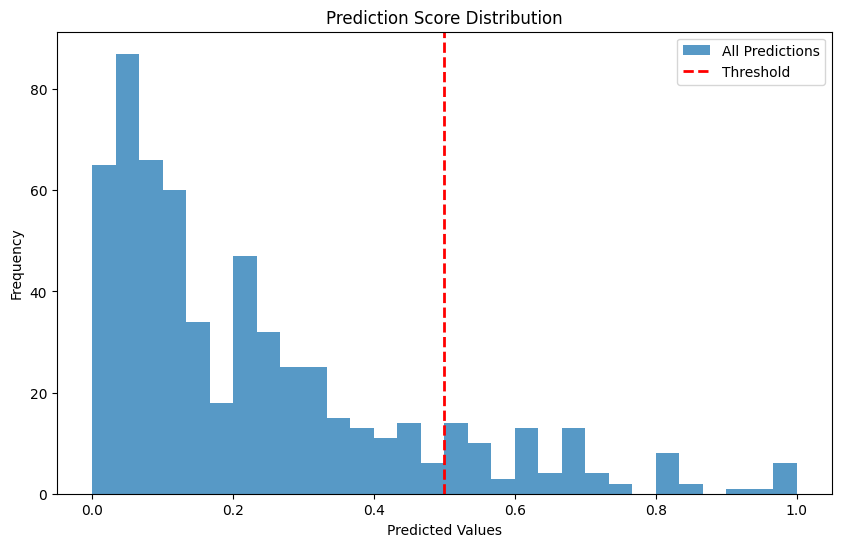

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, alpha=0.75, label='All Predictions')
plt.axvline(x=threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Prediction Score Distribution')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(true_classes, pred_classes) # Need to use the thresholded version! (I.e., with boolean values)

0.8664440734557596

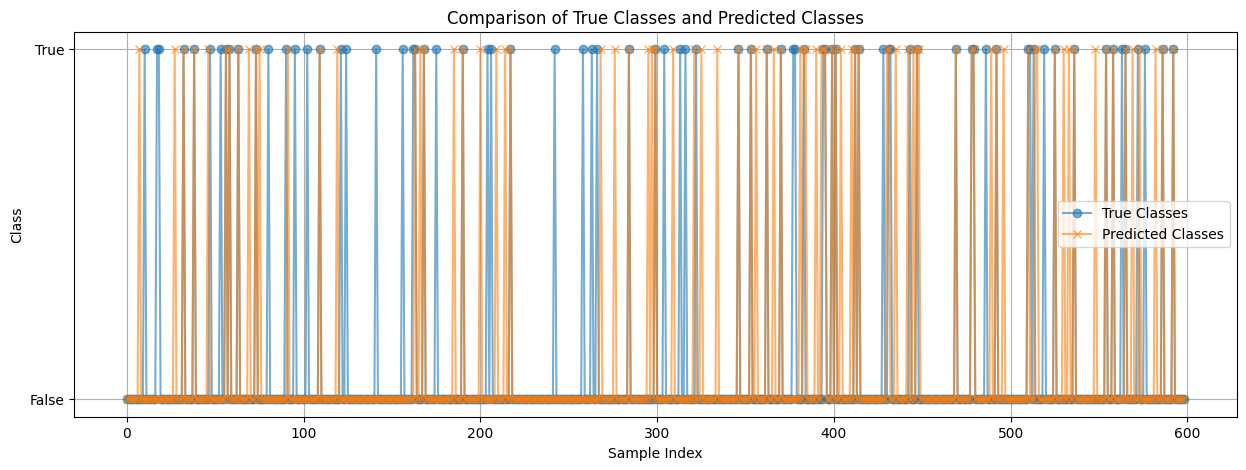

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate index array
indices = np.arange(len(true_classes))

# Creating the plot
plt.figure(figsize=(15, 5))
plt.plot(indices, true_classes, 'o-', label='True Classes', alpha=0.6)
plt.plot(indices, pred_classes, 'x-', label='Predicted Classes', alpha=0.6)

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Comparison of True Classes and Predicted Classes')
plt.yticks([0, 1], ['False', 'True'])  # Set y-ticks to match boolean values
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Counting for true_classes
count_1s_true = np.sum(true_classes)  # Counts the number of 1s
count_0s_true = len(true_classes) - count_1s_true  # Counts the number of 0s

# Counting for pred_classes
count_1s_pred = np.sum(pred_classes)  # Counts the number of 1s
count_0s_pred = len(pred_classes) - count_1s_pred  # Counts the number of 0s

# Printing the results
print("Counts in true_classes:")
print(f"Number of 0s: {count_0s_true}")
print(f"Number of 1s: {count_1s_true}")

print("\nCounts in pred_classes:")
print(f"Number of 0s: {count_0s_pred}")
print(f"Number of 1s: {count_1s_pred}")

Counts in true_classes:
Number of 0s: 524
Number of 1s: 75

Counts in pred_classes:
Number of 0s: 518
Number of 1s: 81


In [ ]:
# Repeat the FNR, FPR computations after abstention
# First we obtain the appropriate lists
X_test_minus_abstention_sf_data = []
for idx in first_70_percent_indices:
  X_test_minus_abstention_sf_data.append(sf_data[idx])

y_pred_minus_abstention_sf_data = y_pred[first_70_percent_indices]
y_test_minus_abstention_sf_data = y_test[first_70_percent_indices]

print(len(y_pred_minus_abstention_sf_data))
print(len(y_pred))

419
599


In [ ]:
# See if accuracy overall has improved
threshold = 0.5
pred_classes_minus_abs = (y_pred_minus_abstention_sf_data >= threshold).astype(int)
true_classes_minus_abs = (y_test_minus_abstention_sf_data >= threshold).astype(int)
accuracy = accuracy_score(true_classes_minus_abs, pred_classes_minus_abs)
print(accuracy)
# Not really

0.8782816229116945


In [ ]:
# Function to calculate FPR and FNR
# Repeat but without the 30% of the points

X_test_minus_abstention_sf_data = np.array([x.lower().strip() for x in X_test_minus_abstention_sf_data]) # Very important line! Don't forget

def calculate_fpr_fnr(predictions, true_classes_minus_abs):
    fp = np.sum((predictions == 1) & (true_classes_minus_abs == 0))
    fn = np.sum((predictions == 0) & (true_classes_minus_abs == 1))
    n = np.sum(true_classes_minus_abs == 0)  # Total number of actual negatives
    print("Total number of actual negatives:", n)
    p = np.sum(true_classes_minus_abs == 1)  # Total number of actual positives
    print("Total number of actual positives:", p)

    fpr = fp / n if n != 0 else 0  # Avoid division by zero
    fnr = fn / p if p != 0 else 0
    return fpr, fnr

# Calculate FPR and FNR for each group
group_fpr_fnr = {}
for group in np.unique(X_test_minus_abstention_sf_data):
    print("\nGroup:", group)
    group_indices = X_test_minus_abstention_sf_data == group
    group_pred_classes = pred_classes_minus_abs[group_indices]
    group_true_classes = true_classes_minus_abs[group_indices]
    print("Accuracy within ", group, ":", accuracy_score(group_true_classes, group_pred_classes))

    if len(group_pred_classes) > 0:  # Ensure there is data to process
        fpr, fnr = calculate_fpr_fnr(group_pred_classes, group_true_classes)
        group_fpr_fnr[group] = (fpr, fnr)
    else:
        group_fpr_fnr[group] = ('No data', 'No data')

# Print results
print("\nFalse Positive Rate and False Negative Rate per group:")
for group, rates in group_fpr_fnr.items():
    print(f"{group}: FPR = {rates[0]}, FNR = {rates[1]}")


Group: asian
Accuracy within  asian : 0.85
Total number of actual negatives: 17
Total number of actual positives: 3

Group: black
Accuracy within  black : 0.9
Total number of actual negatives: 36
Total number of actual positives: 4

Group: hispanic
Accuracy within  hispanic : 0.8636363636363636
Total number of actual negatives: 20
Total number of actual positives: 2

Group: white
Accuracy within  white : 0.8783382789317508
Total number of actual negatives: 300
Total number of actual positives: 37

False Positive Rate and False Negative Rate per group:
asian: FPR = 0.058823529411764705, FNR = 0.6666666666666666
black: FPR = 0.05555555555555555, FNR = 0.5
hispanic: FPR = 0.1, FNR = 0.5
white: FPR = 0.07, FNR = 0.5405405405405406


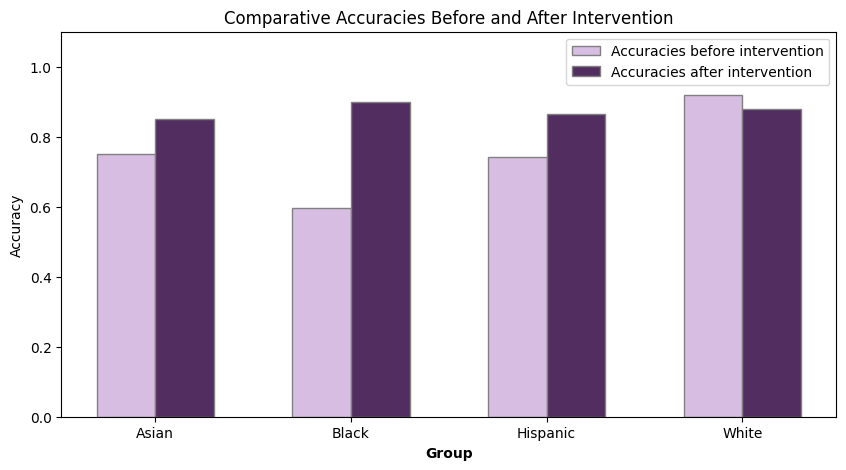

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the groups and their accuracies
groups = ['Asian', 'Black', 'Hispanic', 'White']
acc_before = np.array([0.75, 0.5970149253731343, 0.7428571428571429, 0.919661733615222])
acc_after = np.array([0.85, 0.9, 0.8636363636363636, 0.8783382789317508])

# Width of the bars
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(acc_before))
r2 = [x + barWidth for x in r1]

# Create the plot
plt.figure(figsize=(10, 5))
plt.bar(r1, acc_before, color='#d7bde2', width=barWidth, edgecolor='grey', label='Accuracies before intervention')  # Lighter purple
plt.bar(r2, acc_after, color='#512e5f', width=barWidth, edgecolor='grey', label='Accuracies after intervention')  # Darker purple

# Adding labels and title
plt.xlabel('Group', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth/2 for r in range(len(acc_before))], groups)

# Adjusting y-axis limit
plt.ylim(0, 1.1)  # Ensure there is enough space for the legend within the plot

plt.legend()
plt.title('Comparative Accuracies Before and After Intervention')

# Show the plot
plt.show()

In [ ]:
X_test_minus_abstention_sf_data

In [ ]:
pred_classes_minus_abs

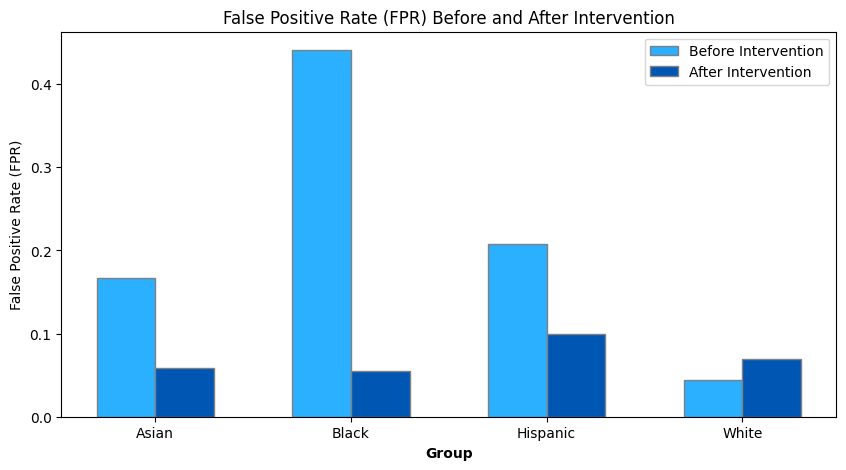

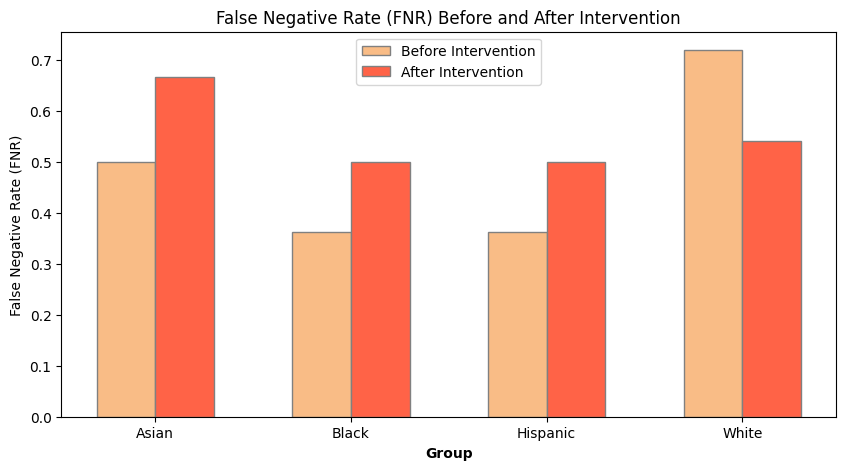

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

groups = ['Asian', 'Black', 'Hispanic', 'White']

# FPR and FNR before intervention
FPR_before = np.array([0.16666666666666666, 0.4411764705882353, 0.20833333333333334, 0.044642857142857144])
FNR_before = np.array([0.5, 0.36363636363636365, 0.36363636363636365, 0.72])

# FPR and FNR after intervention
FPR_after = np.array([0.058823529411764705, 0.05555555555555555, 0.1, 0.07])
FNR_after = np.array([0.6666666666666666, 0.5, 0.5, 0.5405405405405406])

# Width of the bars
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(FPR_before))
r2 = [x + barWidth for x in r1]

# Creating plot for FPR
plt.figure(figsize=(10, 5))
plt.bar(r1, FPR_before, color='#2ab0ff', width=barWidth, edgecolor='grey', label='Before Intervention')
plt.bar(r2, FPR_after, color='#0056b3', width=barWidth, edgecolor='grey', label='After Intervention')
plt.xlabel('Group', fontweight='bold')
plt.ylabel('False Positive Rate (FPR)')
plt.xticks([r + barWidth/2 for r in range(len(FPR_before))], groups)
plt.legend()
plt.title('False Positive Rate (FPR) Before and After Intervention')
plt.show()

# Creating plot for FNR
plt.figure(figsize=(10, 5))
plt.bar(r1, FNR_before, color='#f9bc86', width=barWidth, edgecolor='grey', label='Before Intervention')
plt.bar(r2, FNR_after, color='#ff6347', width=barWidth, edgecolor='grey', label='After Intervention')
plt.xlabel('Group', fontweight='bold')
plt.ylabel('False Negative Rate (FNR)')
plt.xticks([r + barWidth/2 for r in range(len(FNR_before))], groups)
plt.legend()
plt.title('False Negative Rate (FNR) Before and After Intervention')
plt.show()

In [ ]:
# Finally, I will compute other fairness metrics

# 1. EQUAL OPPORTUNITY DIFFERENCE

groups = np.unique(sf_data)
X_test_sf_data = np.array([x.lower().strip() for x in X_test_sf_data])

def true_positive_rate(true, pred):
    true_positive = np.logical_and(true == 1, pred == 1).sum()
    actual_positive = (true == 1).sum()
    return true_positive / actual_positive if actual_positive != 0 else 0

# Calculating TPR for each group
tprs = {}
for group in groups:
    indices = X_test_sf_data == group
    tprs[group] = true_positive_rate(true_classes[indices], pred_classes[indices])

# Selecting reference groups: Adjust 'White' and 'Black' as needed for your analysis
eop_diffs = {g: tprs[g] - tprs['white'] for g in groups if g != 'white'}
print("Equal Opportunity Differences:", eop_diffs)

Equal Opportunity Differences: {'asian': 0.21999999999999997, 'black': 0.3563636363636363, 'hispanic': 0.3563636363636363}


In [ ]:
# Next, we compute these after our intervention
# This is the same code for all of the fairness interventions; preparing the correct lists
# before and after abstention

X_test_minus_abstention_sf_data = []
for idx in first_70_percent_indices:
  X_test_minus_abstention_sf_data.append(sf_data[idx])

groups = np.unique(sf_data)
X_test_minus_abstention_sf_data = np.array([x.lower().strip() for x in X_test_minus_abstention_sf_data])
y_pred_minus_abstention_sf_data = y_pred[first_70_percent_indices]
y_test_minus_abstention_sf_data = y_test[first_70_percent_indices]
threshold = 0.5
pred_classes_minus_abs = (y_pred_minus_abstention_sf_data >= threshold).astype(int)
true_classes_minus_abs = (y_test_minus_abstention_sf_data >= threshold).astype(int)

In [ ]:
def true_positive_rate(true, pred):
    true_positive = np.logical_and(true == 1, pred == 1).sum()
    actual_positive = (true == 1).sum()
    return true_positive / actual_positive if actual_positive != 0 else 0

# Calculating TPR for each group
tprs = {}
for group in groups:
    indices = X_test_minus_abstention_sf_data == group
    tprs[group] = true_positive_rate(true_classes_minus_abs[indices], pred_classes_minus_abs[indices])

# Selecting reference groups: Adjust 'White' and 'Black' as needed for your analysis
eop_diffs = {g: tprs[g] - tprs['white'] for g in groups if g != 'white'}
print("Equal Opportunity Differences:", eop_diffs)

Equal Opportunity Differences: {'asian': -0.12612612612612617, 'black': 0.040540540540540515, 'hispanic': 0.040540540540540515}


In [ ]:
# 2. AVERAGE OODS DIFFERENCE

def false_positive_rate(true, pred):
    false_positive = np.logical_and(true == 0, pred == 1).sum()
    actual_negative = (true == 0).sum()
    return false_positive / actual_negative if actual_negative != 0 else 0

# Calculating FPR for each group
fprs = {}
for group in groups:
    indices = X_test_sf_data == group
    fprs[group] = false_positive_rate(true_classes[indices], pred_classes[indices])

# Average Odds Difference
aod_diffs = {g: 0.5 * ((fprs[g] - fprs['white']) + (tprs[g] - tprs['white'])) for g in groups if g != 'white'}
print("Average Odds Differences:", aod_diffs)

Average Odds Differences: {'asian': -0.0020511583011583318, 'black': 0.21853707699295932, 'hispanic': 0.10211550836550835}


In [ ]:
# And after abstention

# Calculating FPR for each group
fprs = {}
for group in groups:
    indices = X_test_minus_abstention_sf_data == group
    fprs[group] = false_positive_rate(true_classes_minus_abs[indices], pred_classes_minus_abs[indices])

# Average Odds Difference
aod_diffs = {g: 0.5 * ((fprs[g] - fprs['white']) + (tprs[g] - tprs['white'])) for g in groups if g != 'white'}
print("Average Odds Differences:", aod_diffs)

Average Odds Differences: {'asian': -0.06865129835718073, 'black': 0.01304804804804803, 'hispanic': 0.03527027027027026}


In [ ]:
# 3. DISPARATE IMPACT

def selection_rate(pred):
    return pred.mean()

# Calculating Selection Rate for each group
srs = {}
for group in groups:
    indices = X_test_sf_data == group
    srs[group] = selection_rate(pred_classes[indices])

# Disparate Impact
disparate_impact = {g: srs[g] / srs['white'] if srs['white'] != 0 else 0 for g in groups if g != 'white'}
print("Disparate Impact:", disparate_impact)

Disparate Impact: {'asian': 4.37962962962963, 'black': 9.412935323383085, 'hispanic': 6.006349206349206}


In [ ]:
# And with abstention
srs = {}
for group in groups:
    indices = X_test_minus_abstention_sf_data == group
    srs[group] = selection_rate(pred_classes_minus_abs[indices])

# Disparate Impact
disparate_impact = {g: srs[g] / srs['white'] if srs['white'] != 0 else 0 for g in groups if g != 'white'}
print("Disparate Impact:", disparate_impact)

Disparate Impact: {'asian': 0.886842105263158, 'black': 0.886842105263158, 'hispanic': 1.2093301435406698}


In [ ]:
# 4. DEMOGRAPHIC PARITY DIFFERENCE

# Calculating Selection Rate for each group
srs = {}
for group in groups:
    indices = X_test_sf_data == group
    srs[group] = selection_rate(pred_classes[indices])

dp_diffs = {g: srs[g] - srs['white'] for g in groups if g != 'white'}
print("Demographic Parity Differences:", dp_diffs)

Demographic Parity Differences: {'asian': 0.19291754756871035, 'black': 0.48023098040453127, 'hispanic': 0.28577469042585324}


In [ ]:
# And with abstention

# Calculating Selection Rate for each group
srs = {}
for group in groups:
    indices = X_test_minus_abstention_sf_data == group
    srs[group] = selection_rate(pred_classes_minus_abs[indices])

dp_diffs = {g: srs[g] - srs['white'] for g in groups if g != 'white'}
print("Demographic Parity Differences:", dp_diffs)

Demographic Parity Differences: {'asian': -0.012759643916913935, 'black': -0.012759643916913935, 'hispanic': 0.023603992446722413}


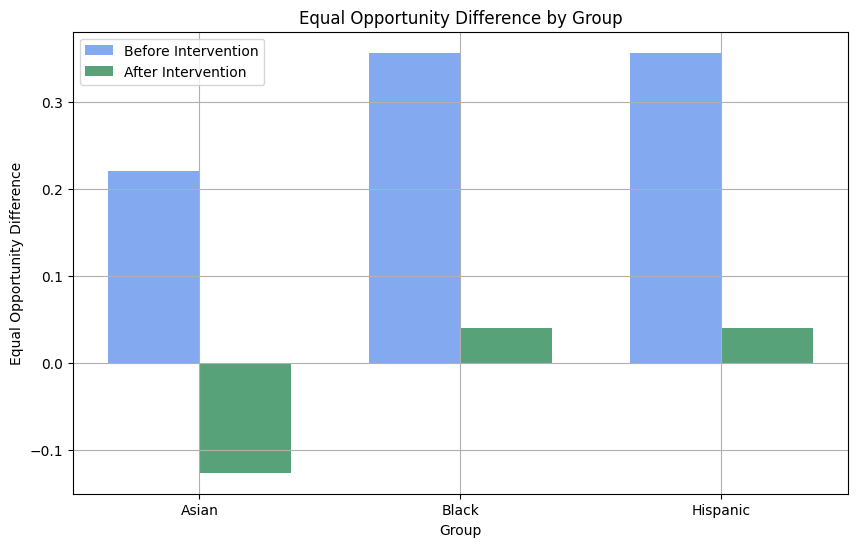

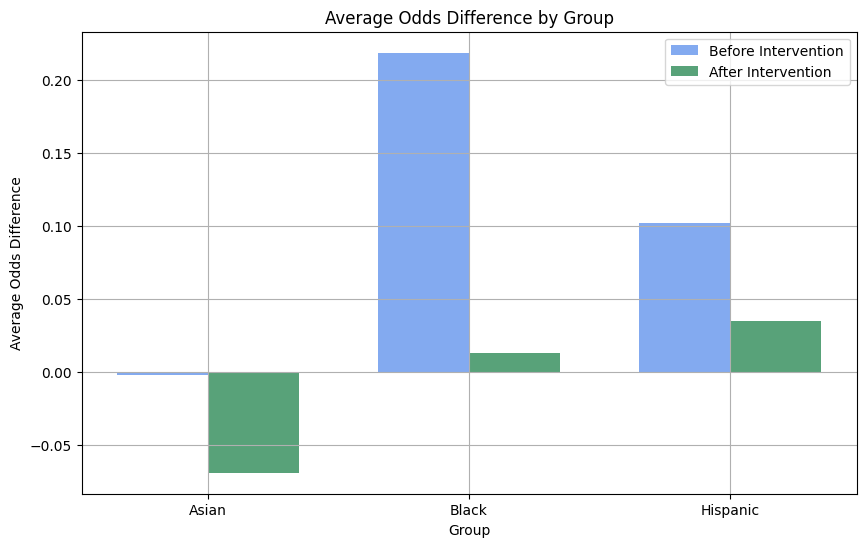

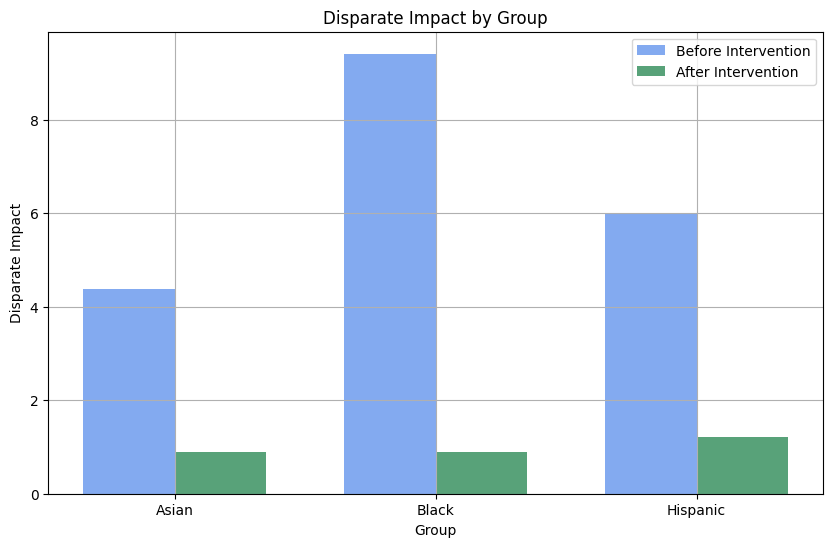

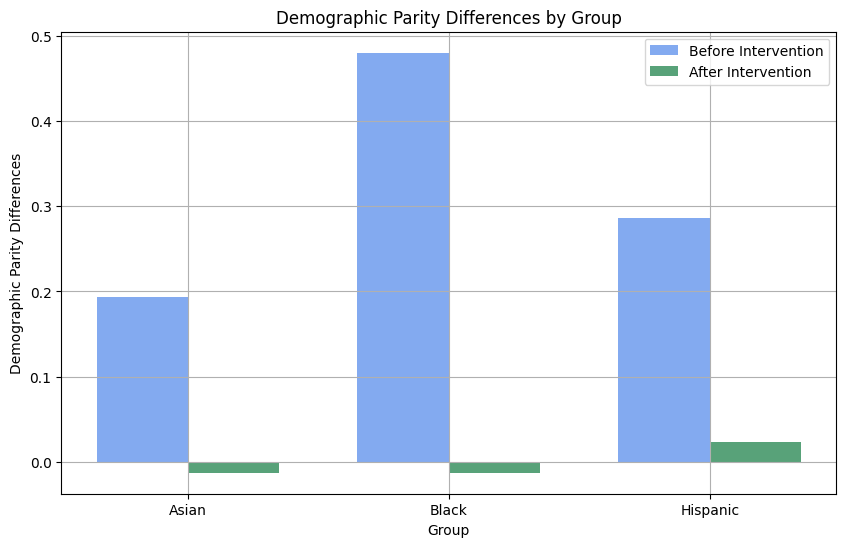

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the groups and their order for plotting
groups = ['Asian', 'Black', 'Hispanic']
colors = ['blue', 'green', 'red']  # Colors for each group

# Metric data dictionaries
equal_opportunity_diff = {
    "before": {'Asian': 0.22, 'Black': 0.3564, 'Hispanic': 0.3564},
    "after": {'Asian': -0.1261, 'Black': 0.0405, 'Hispanic': 0.0405}
}

average_odds_diff = {
    "before": {'Asian': -0.0021, 'Black': 0.2185, 'Hispanic': 0.1021},
    "after": {'Asian': -0.0687, 'Black': 0.0130, 'Hispanic': 0.0353}
}

disparate_impact = {
    "before": {'Asian': 4.38, 'Black': 9.41, 'Hispanic': 6.01},
    "after": {'Asian': 0.887, 'Black': 0.887, 'Hispanic': 1.209}
}

demographic_parity_diff = {
    "before": {'Asian': 0.1929, 'Black': 0.4802, 'Hispanic': 0.2858},
    "after": {'Asian': -0.0128, 'Black': -0.0128, 'Hispanic': 0.0236}
}

metrics = {
    "Equal Opportunity Difference": equal_opportunity_diff,
    "Average Odds Difference": average_odds_diff,
    "Disparate Impact": disparate_impact,
    "Demographic Parity Differences": demographic_parity_diff
}

# Plotting function
def plot_fairness_metric(metric_name, metric_data):
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(groups))

    before_values = [metric_data['before'].get(group, 0) for group in groups]
    after_values = [metric_data['after'].get(group, 0) for group in groups]

    bars_before = ax.bar(index, before_values, bar_width, label='Before Intervention', alpha=0.8, color='cornflowerblue')
    bars_after = ax.bar(index + bar_width, after_values, bar_width, label='After Intervention', alpha=0.8, color='seagreen')

    ax.set_xlabel('Group')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Group')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(groups)
    ax.legend()

    plt.grid(True)
    plt.show()

# Generate plots for each metric
for metric_name, metric_data in metrics.items():
    plot_fairness_metric(metric_name, metric_data)

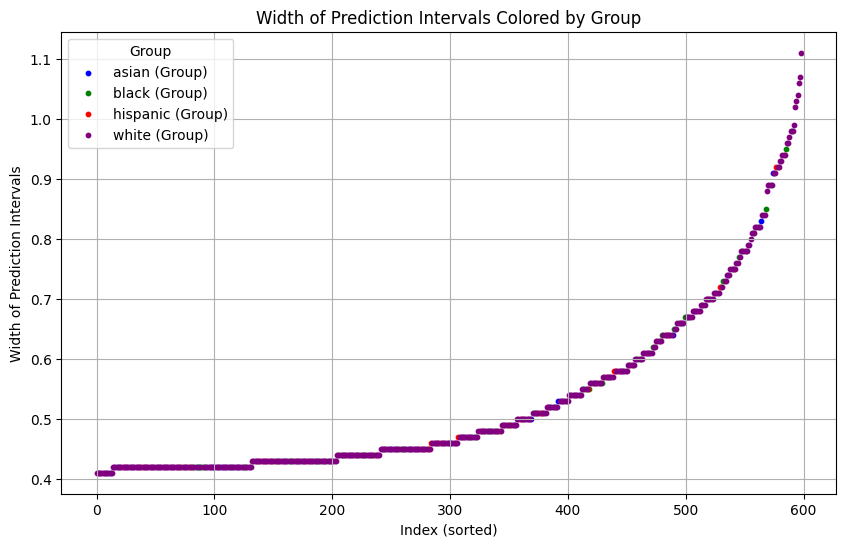

In [ ]:
# Last check: How does the prediction interval width distribute across groups?

# y_pis_width is an array of prediction interval widths
# sf_data is an array of group labels, corresponding one-to-one with elements in y_pis

# Sorting y_pis_width and getting indices to sort other arrays consistently
sorted_indices = np.argsort(y_pis_width)
sorted_y_pis_width = y_pis_width[sorted_indices]
sorted_groups = sf_data[sorted_indices]

# Define unique groups and corresponding colors
groups = np.unique(sf_data)
colors = ['blue', 'green', 'red', 'purple']  # Ensure there are enough colors for all groups
color_dict = {group: color for group, color in zip(groups, colors)}

# Create a scatter plot with colors based on group membership
plt.figure(figsize=(10, 6))

# Generate plot for each group
for group, color in color_dict.items():
    # Get indices for data points belonging to the current group
    group_mask = (sorted_groups == group)
    # Plot data points for the current group
    plt.scatter(np.arange(len(sorted_y_pis_width))[group_mask], sorted_y_pis_width[group_mask],
                s=10, color=color, label=f'{group} (Group)')

plt.xlabel('Index (sorted)')
plt.ylabel('Width of Prediction Intervals')
plt.title('Width of Prediction Intervals Colored by Group')
plt.legend(title='Group')
plt.grid(True)
plt.show()

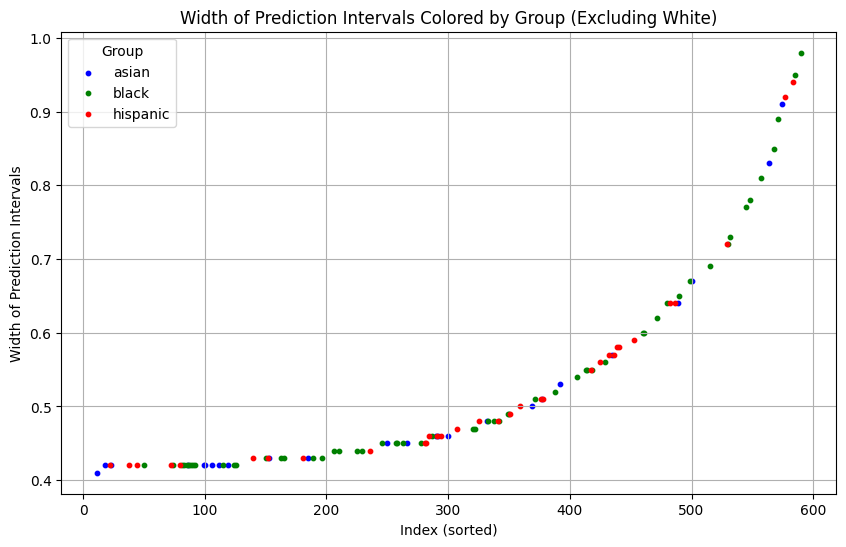

In [ ]:
# Plotting without 'white' --> we see that the minority groups are not disproportionately
# represented in the higher widths (i.e, + uncertainty)

# y_pis_width is an array of prediction interval widths
# sf_data is an array of group labels, corresponding one-to-one with elements in y_pis

# Sorting y_pis and getting indices to sort other arrays consistently
sorted_indices = np.argsort(y_pis_width)
sorted_y_pis_width = y_pis_width[sorted_indices]
sorted_groups = sf_data[sorted_indices]

# Define unique groups and corresponding colors
groups = np.unique(sf_data)
colors = ['blue', 'green', 'red', 'purple']  # Ensure there are enough colors for all groups
color_dict = {group: color for group, color in zip(groups, colors)}

# Create a scatter plot with colors based on group membership
plt.figure(figsize=(10, 6))

# Generate plot for each group except 'white'
for group, color in color_dict.items():
    if group != 'white':  # Skip the 'white' group
        # Get indices for data points belonging to the current group
        group_mask = (sorted_groups == group)
        # Plot data points for the current group
        plt.scatter(np.arange(len(sorted_y_pis_width))[group_mask], sorted_y_pis_width[group_mask],
                    s=10, color=color, label=f'{group}')

plt.xlabel('Index (sorted)')
plt.ylabel('Width of Prediction Intervals')
plt.title('Width of Prediction Intervals Colored by Group (Excluding White)')
plt.legend(title='Group')
plt.grid(True)
plt.show()